# W207 Final Project - "Random Acts of Pizza"
### Predicting altruism through free pizza

#### Team Members: Gurdit Chahal, Shan He, Joanna Huang,  Emmy Lau

#### Table of Contents

1. Introduction
2. Exploratory Data Analysis
3. Baseline
4. Feature Engineering
5. Model Selection & Tuning
6. Error Analysis
7. Conclusion


### 1. Introduction

The Random Acts of Pizza subreddit is a place where people post and request free pizza from others on the Internet. In this project, our objective is to create an algorithm that predicts whether or not a request will receive pizza using the provided dataset of 5671 requests collected from the Reddit community Random Acts of Pizza between December 8, 2010 and September 29, 201. Our final model is a combination of models trained on various textual and meta-data features, including information such as: time of the request, activity of the requester, and community-age of the requester.

#### Initialize packages and load in data

In [5]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import os
import string
import time
import datetime
from collections import Counter

# EDA plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.svm import LinearSVC as LSVC
from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

from sklearn.decomposition import LatentDirichletAllocation as LDA
import lda
import gensim
from gensim import utils
import xgboost as xgb

In [7]:
# Read json file
train_json = json.load(open('train.json'))

# Normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# Extract output labels. 0 means the user doesn't receive pizza & 1 means the user receives pizza
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

# Read json file
test_json = json.load(open('test.json'))

# Normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)

Train shape:  (4040, 32)
Test shape:  (1631, 17)


Based on the observed shapes of the two datasets, there appears to be a discrepancy with the training set having 32 columns and the test set only having 17. We take a closer look to better understand the reason behind this discrepancy.

In [8]:
# Print out columns that are only in the train dataset
train_only_columns = set(train_json_df.columns.values)-set(test_json_df.columns.values)
print("Columns in Train but not Test:\n",train_only_columns)

# Print out columns that are only in the test dataset
test_only_columns = set(test_json_df.columns.values)-set(train_json_df.columns.values)
print("\nColumns in Test but not Train:",test_only_columns)

Columns in Train but not Test:
 {'requester_number_of_comments_in_raop_at_retrieval', 'requester_days_since_first_post_on_raop_at_retrieval', 'post_was_edited', 'requester_user_flair', 'requester_received_pizza', 'requester_account_age_in_days_at_retrieval', 'number_of_downvotes_of_request_at_retrieval', 'request_text', 'requester_number_of_posts_at_retrieval', 'requester_number_of_comments_at_retrieval', 'request_number_of_comments_at_retrieval', 'requester_upvotes_minus_downvotes_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'requester_upvotes_plus_downvotes_at_retrieval', 'requester_number_of_posts_on_raop_at_retrieval'}

Columns in Test but not Train: set()


#### Details on the additional columns in the train set:

* request_text/post_was_edited: Since posts are often edited after a successful request, this request_text column is not the most accurate. Instead, request_text_edit_aware, which is available in both the train and test sets, will be used. This edit aware version of "request_text" strips edited comments indicating the success of the request.

* *_at_retrieval: For our purposes of real-time prediction, _at_request columns are more relevant.

* requester_user_flair: This is a post-receipt of pizza feature and thus will not be a useful indicator of results.

* requester_received_pizza: To be predicted

For these reasons, we will move forward with only the columns in both the train and test set. 

In [9]:
# Create new dataframe with only the shared columns
train_w_test = train_json_df[test_json_df.columns.values]

#### Split the training data into training data and dev data 
We will use 80% of our training data for exploratory data analysis, feature engineering and model training while the remaining 20% will be set aside as our development data set.

In [10]:
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_w_test, train_labels, test_size=0.2, random_state=12)

### 2. Exploratory Data Analysis
We'll first take a look at the non-text metadata.

In [11]:
train_data.describe()

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,3232.000000,3232.000000,3232.00000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3.232000e+03,3.232000e+03
mean,256.662929,16.682342,116.69276,0.633045,21.387995,0.058787,18.383045,1141.690903,3536.765161,1.342819e+09,1.342816e+09
std,301.711688,72.319691,193.74547,3.274447,50.104315,0.305135,21.934935,2980.726140,17408.745325,2.327255e+07,2.327194e+07
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,1.306095e+09,1.306091e+09
25%,3.729690,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,1.320443e+09,1.320440e+09
50%,158.827159,0.000000,26.00000,0.000000,5.000000,0.000000,11.000000,177.500000,355.000000,1.342578e+09,1.342575e+09
75%,391.942080,0.000000,146.00000,0.000000,22.000000,0.000000,27.000000,1183.250000,2335.000000,1.364390e+09,1.364386e+09
max,2809.750787,785.457685,994.00000,88.000000,867.000000,5.000000,186.000000,87911.000000,789287.000000,1.381552e+09,1.381523e+09


Based on this initial look at the data, there doesn't appear to be anything unusual with the values. To extract more meaningful information around when the post was made, we will convert the unix_timestamp_of_request variable into a more interpretable form.

To understand the relationship between the features and whether or not a request is fulfilled, let's take a look at how the variables are correlated.

/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


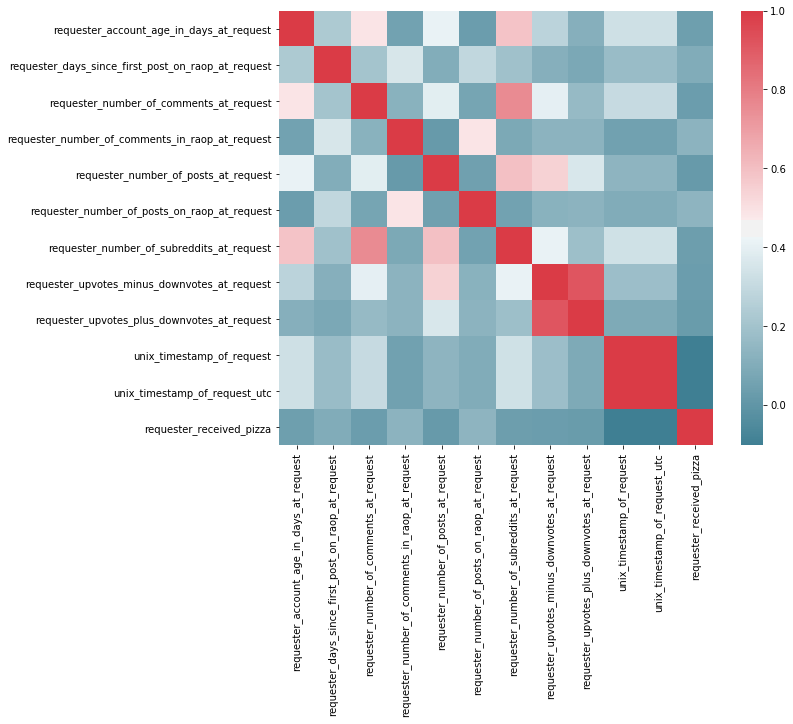

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
train_w_test['requester_received_pizza'] = train_json_df['requester_received_pizza']
corr = train_w_test.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Looking at the rightmost column, we can see how the features are related to requester_received_pizza. The following features seem to be most correlated and can be features to include when training our model: requester_account_age_in_days_at_request, requester_days_since_first_post_on_raop_at_request, requester_number_of_comments_in_raop_at_request, requester_number_of_posts_on_raop_at_request and unix_timestamp_of_request.

Next, we compare the features for fulfilled and unfulfilled requests.

In [13]:
fulfilled_requests = train_w_test.loc[train_w_test['requester_received_pizza']==True]
unfulfilled_requests = train_w_test.loc[train_w_test['requester_received_pizza']==False]

#### Request Time

In [14]:
# Extract day of week from request timestamp
train_w_test['datetime'] = pd.to_datetime(train_w_test["unix_timestamp_of_request"], unit = 's')
train_w_test['dayofweek'] = train_w_test['datetime'].dt.dayofweek

# See rate of fulfillment by day of week
fulfilled_dow = pd.DataFrame()
fulfilled_dow['dayofweek'] =[0,1,2,3,4,5,6]
fulfilled_dow['fulfilled_count'] = train_w_test[train_w_test['requester_received_pizza']==True]['dayofweek'].value_counts(sort=False)
fulfilled_dow['total_post_per_dow'] = train_w_test['dayofweek'].value_counts(sort=False)
fulfilled_dow['perc'] = round(fulfilled_dow['fulfilled_count']/fulfilled_dow['total_post_per_dow'],2)
del fulfilled_dow['fulfilled_count']
del fulfilled_dow['total_post_per_dow']
print(fulfilled_dow)

   dayofweek  perc
0          0  0.26
1          1  0.23
2          2  0.23
3          3  0.30
4          4  0.26
5          5  0.22
6          6  0.23


/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Sunday, Wednesday and Thursday seem to have a higher rate of success by 1-8 percentage points. Thus, day of week is an important feature to include in our model.

In [15]:
train_w_test['hour']=train_w_test['datetime'].dt.hour

# See rate of fulfillment by hour
fulfilled_hour = pd.DataFrame()
fulfilled_hour['hour'] =range(24)
fulfilled_hour['fulfilled_count'] = train_w_test[train_w_test['requester_received_pizza']==True]['hour'].value_counts(sort=False)
fulfilled_hour['total_post_per_hour'] = train_w_test['hour'].value_counts(sort=False)
fulfilled_hour['perc'] = round(fulfilled_hour['fulfilled_count']/fulfilled_hour['total_post_per_hour'],2)
del fulfilled_hour['fulfilled_count']
del fulfilled_hour['total_post_per_hour']
print(fulfilled_hour.describe())

            hour       perc
count  24.000000  24.000000
mean   11.500000   0.232917
std     7.071068   0.062309
min     0.000000   0.120000
25%     5.750000   0.207500
50%    11.500000   0.230000
75%    17.250000   0.280000
max    23.000000   0.340000


/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


With a fulfillment rate difference of 22% between the max and min of all hours, hour of day seems like an important feature to include in our model.

#### Requester Account and Activity

Now, let's take a look at the various requester feature differences between those whose requests were fulfilled, and those whose requests were not.

In [16]:
def fulfilled_or_not(feature):
    print(feature)
    print('Mean for Fulfilled Requests: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==True][feature].mean(),2)))
    print('Standard dev: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==True][feature].std(),2)))
    print('Mean for Unfulfilled Requests: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==False][feature].mean(),2)))
    print('Standard dev: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==False][feature].std(),2)))
    print('\n')

In [17]:
fulfilled_or_not('requester_account_age_in_days_at_request') 
fulfilled_or_not('requester_days_since_first_post_on_raop_at_request') 
fulfilled_or_not('requester_number_of_comments_at_request') 
fulfilled_or_not('requester_number_of_comments_in_raop_at_request') 
fulfilled_or_not('requester_number_of_posts_at_request') 
fulfilled_or_not('requester_number_of_posts_on_raop_at_request')

requester_account_age_in_days_at_request
Mean for Fulfilled Requests: 276.77
Standard dev: 312.79
Mean for Unfulfilled Requests: 247.35
Standard dev: 299.8


requester_days_since_first_post_on_raop_at_request
Mean for Fulfilled Requests: 28.56
Standard dev: 96.77
Mean for Unfulfilled Requests: 12.45
Standard dev: 59.19


requester_number_of_comments_at_request
Mean for Fulfilled Requests: 126.53
Standard dev: 202.33
Mean for Unfulfilled Requests: 111.37
Standard dev: 190.17


requester_number_of_comments_in_raop_at_request
Mean for Fulfilled Requests: 1.43
Standard dev: 5.91
Mean for Unfulfilled Requests: 0.39
Standard dev: 1.94


requester_number_of_posts_at_request
Mean for Fulfilled Requests: 23.44
Standard dev: 52.5
Mean for Unfulfilled Requests: 21.0
Standard dev: 50.35


requester_number_of_posts_on_raop_at_request
Mean for Fulfilled Requests: 0.14
Standard dev: 0.53
Mean for Unfulfilled Requests: 0.04
Standard dev: 0.22




#### Upvotes vs Downvotes

In [18]:
fulfilled_or_not('requester_upvotes_minus_downvotes_at_request')
fulfilled_or_not('requester_upvotes_plus_downvotes_at_request')

requester_upvotes_minus_downvotes_at_request
Mean for Fulfilled Requests: 1372.06
Standard dev: 5419.69
Mean for Unfulfilled Requests: 1090.9
Standard dev: 2956.58


requester_upvotes_plus_downvotes_at_request
Mean for Fulfilled Requests: 4923.7
Standard dev: 42166.37
Mean for Unfulfilled Requests: 3358.02
Standard dev: 17467.64




### Text Features

Next, we'll take a closer look at the text. To start, we can look at Non-Negative Matrix Factorization (NMF) for a better understanding of the request text topic breakdown.

In [19]:
from sklearn.decomposition import NMF
no_features = 1000
no_topics = 20
no_top_words = 10

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train_data['request_text_edit_aware'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Print most common topics
topics_vec = np.argmax(nmf.transform(tfidf),axis=1)
imp_topics = Counter(topics_vec).most_common(5)
print('Top five most common topics with counts: ' + str(imp_topics))

# Derived topics with the top 10 words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("NMF Topics:\n")
display_topics(nmf, tfidf_feature_names, no_top_words)

Top five most common topics with counts: [(0, 1008), (1, 175), (3, 171), (2, 169), (11, 130)]
NMF Topics:

Topic 0:
ve job like pizza got work know new going don
Topic 1:
http com imgur jpg www reddit comments proof pic youtube
Topic 2:
love pizza tonight buy hut nice night craving pie like
Topic 3:
pay forward ll promise friday paycheck soon check gladly comes
Topic 4:
help need dinner appreciate willing feed asking tonight hoping kids
Topic 5:
really appreciate use pizza right don hey craving starving wednesday
Topic 6:
college student broke finals poor students kid studying summer appreciate
Topic 7:
money spent days buy tight pizza kind don right left
Topic 8:
hungry broke pretty super dont right sure feeling tomorrow roommates
Topic 9:
just want story sob pizza don craving moved sad need
Topic 10:
food house stamps today month need days dont family fridge
Topic 11:
week paid friday till don rent bank buy account end
Topic 12:
appreciated greatly pizza super thank picky weeks tomor

The top five topics can be generally described by the following:
- Topic 0: Job/Work
- Topic 1: Inclusion of proof
- Topic 2: Love/Craving
- Topic 3: Promise of reciprocity
- Topic 11: Money/Rent

#### Word Vizualization

Next we dive a little deeper, looking at the common phrases within the posts and the differences between fulfilled and unfulfilled requests.

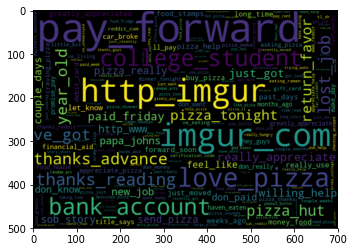

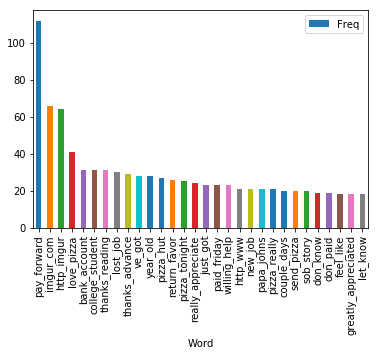

In [20]:
def word_join(string,joiner='_'):
    return joiner.join(string.split()) 
v_join=np.vectorize(word_join)

CV=CountVectorizer(stop_words='english',ngram_range=(2,2))
Ctbow=CV.fit_transform(train_data[train_labels==1]['request_text_edit_aware'])
vocab=v_join(CV.get_feature_names())
freqs=list(Ctbow.toarray().sum(axis=0))
word_score=dict(zip(vocab,freqs))
wc=WordCloud(max_words=200,height=500,width=700).fit_words(word_score)
plt.imshow(wc, interpolation='bilinear')
word_score2=sorted(list(zip(vocab,freqs)), key=lambda x: -x[1])
got_pizza=pd.DataFrame(word_score2[:30],columns = ['Word', 'Freq'])
got_pizza.plot.bar(x='Word',y='Freq')

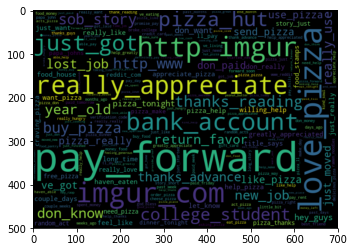

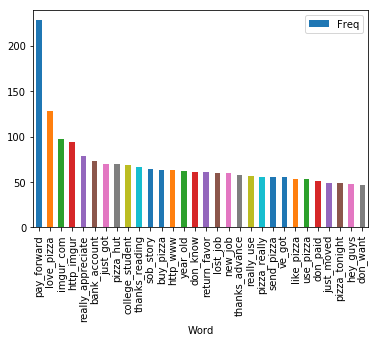

In [21]:
CV=CountVectorizer(stop_words='english',ngram_range=(2,2))
Ctbow=CV.fit_transform(train_data[train_labels==0]['request_text_edit_aware'])
vocab=v_join(CV.get_feature_names())
freqs=list(Ctbow.toarray().sum(axis=0))
word_score=dict(zip(vocab,freqs))
wc=WordCloud(max_words=200,height=500,width=700).fit_words(word_score)
plt.imshow(wc, interpolation='bilinear')
word_score2=list(zip(vocab,freqs))
word_score2=sorted(word_score2, key=lambda x: -x[1])
no_pizza=pd.DataFrame(word_score2[:30],columns = ['Word', 'Freq'])
no_pizza.plot.bar(x='Word',y='Freq')

We chose bigrams as unigrams alone made little sense and trigrams were too rare to be useful. From these visuals we can start to get an idea of potential differentiatiors in terms of post content that might make a difference to whether a user gets pizza or not. There are some interesting differences such as Redditors getting the pizza talking about "lost job" vs those not saying "new job". Even amongst common phrases, what's interesting is how those who didn't get pizza mentioned "love pizza" and "pay forward" more often.

### 3. Baseline

As a baseline, we have chosen the Naive Bayes model combined with a bag of words approach since Naive Bayes is the most straightforward modeling approach to take in terms of model assumptions (feature independence) and complexity. Furthermore, Naive Bayes works well with text as word counts are natural features for Naive Bayes since we calculate probabilities from observation counts.

In [22]:
# Use standard CountVectorizer to transform the training data and dev data 
vectorizer = CountVectorizer() 
train_bag_of_words = vectorizer.fit_transform(train_data['request_text_edit_aware'])
dev_bag_of_words = vectorizer.transform(dev_data['request_text_edit_aware'])

# Create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(nb, parameters)
    
# train the MultinomialNB
clf.fit(train_bag_of_words, train_labels)

pred_dev_prob = clf.predict_proba(dev_bag_of_words)[:,0]

print(clf.best_params_)
print("auc score using CountVectorizer & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))

{'alpha': 8.789090909090909}
auc score using CountVectorizer & MultinomialNB = 0.5988939144736842


 We see with an auc of .598, our baseline does better than randomly guessing (auc of .5) but not by too much.

**X. Error Analysis**

1. Missing vocabulary for test text features
2. Find misclassified dev data
    - LDA/NMF for wrong categorization
    - Find common pattern

Copied from GC's workbook

In [24]:
#combine text features
train_data['full_text']=train_data['request_text_edit_aware'] +' '+train_data['request_title']
dev_data['full_text']=dev_data['request_text_edit_aware'] +' '+dev_data['request_title']


/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# Narratives per Standford paper
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "Friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]



In [27]:
import string
from nltk.stem.porter import PorterStemmer
def pre_proccess(s):
    s = re.sub("[^\w']|_", " ", s) 
    s=s.translate(str.maketrans(' ',' ',string.punctuation))#strip punctuation before looking
    s= re.sub(' +',' ', s) #remove extra spaces
    s=s.lower()
   # p_stemmer = PorterStemmer()
    #s = ' '.join([p_stemmer.stem(i) for i in s.split()])    
    return s


In [28]:
#https://www.timeanddate.com/calendar/aboutseasons.html
def ts_to_season(month):
    if month>=3 and month<=5:
        return "spring"
    elif month>=6 and month <=8:
        return "summer"
    elif month>=9 and month <=11:
        return "fall"
    else:
        return "winter"

In [29]:
def construct_ft_mat(train_data):
    feat_mat=pd.DataFrame()
    
    #temporal features
    feat_mat['hour_request']=pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.hour
    feat_mat['day_request']=pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.day
    feat_mat['day_request']=feat_mat['day_request'].apply(lambda x: 0 if x<16 else 1)
    feat_mat['season_request']=pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.month
    feat_mat['season_request']=feat_mat['season_request'].apply(ts_to_season)
    feat_mat['is_spring']=feat_mat['season_request'].apply(lambda x: 1 if x=='spring' else 0)
    feat_mat['is_summer']=feat_mat['season_request'].apply(lambda x: 1 if x=='summer' else 0)
    feat_mat['is_fall']=feat_mat['season_request'].apply(lambda x: 1 if x=='fall' else 0)
    feat_mat['is_winter']=feat_mat['season_request'].apply(lambda x: 1 if x=='winter' else 0)
    del feat_mat['season_request']
    
    #check if requester was a previous giver
    #feat_mat['was_giver']=train_data['requester_username'].apply(lambda x: 1 if x in previous_givers else 0)
    
    feat_mat['first_post']=np.log(train_data['requester_days_since_first_post_on_raop_at_request']+1)
    feat_mat['upvotes_minus_downvotes']=train_data['requester_upvotes_minus_downvotes_at_request']
    feat_mat['upvotes_plus_downvotes_at_request']=np.log(train_data['requester_upvotes_plus_downvotes_at_request']+1)
    upvotes=train_data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request'] + row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    downvotes=train_data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request']- row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    feat_mat['upvotes']=upvotes
    feat_mat['vote_ratio']=upvotes/(upvotes+downvotes+1)
    
    feat_mat['req_age']=np.log(train_data['requester_account_age_in_days_at_request']+1)
    feat_mat['num_subs']=np.log(train_data['requester_number_of_subreddits_at_request']+1)
    feat_mat['num_posts']=np.log(train_data['requester_number_of_posts_at_request']+1)
    feat_mat['pizza_activity']=np.log(train_data['requester_number_of_posts_on_raop_at_request']+1)
    feat_mat['len_request']=np.log(train_data['request_text_edit_aware'].apply(len)+1)
    feat_mat['len_title']=np.log(train_data['request_title'].apply(len)+1)
    #feat_mat['len_name']=train_data['requester_username'].apply(len)
    feat_mat['pizza_comments']=np.log(train_data['requester_number_of_comments_in_raop_at_request']+1)
    # reciprocity indicator
    #feat_mat['reciprocity'] = train_data['request_text_edit_aware'].apply(lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor", x) 
                                               #else 0)
    #feat_mat['image_in_text'] = train_data['request_text_edit_aware'].str.contains('imgur.com|.jpg|.png|.jpeg', case=False).apply(lambda x: 1 if x else 0)
    #feat_mat['politeness'] = train_data['request_text_edit_aware'].apply(lambda x: 1 if re.search("thank|appreciate|advance", x) else 0)
    feat_mat['reciprocity'] = train_data['full_text'].apply(lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor", x) 
                                               else 0)
    feat_mat['image_in_text'] = train_data['full_text'].str.contains('imgur.com|.jpg|.png|.jpeg', case=False).apply(lambda x: 1 if x else 0)
    feat_mat['politeness'] = train_data['full_text'].apply(lambda x: 1 if re.search("thank|appreciate|advance", x) else 0)
    
    return feat_mat

In [30]:
def find_narr(narr,s):
    ct=0
    for word in narr:
        ct+=s.split().count(word)
    return ct/len(s.split())

In [31]:
feat_mat=construct_ft_mat(train_data)

dev_mat=construct_ft_mat(dev_data)


In [32]:
train_text_clean=train_data['full_text'].apply(lambda s:pre_proccess(s))
dev_text_clean=dev_data['full_text'].apply(lambda s: pre_proccess(s))     
for n in narratives:
    feat_mat[n[0]]=train_text_clean.apply(lambda s: find_narr(n,s))
    dev_mat[n[0]]=dev_text_clean.apply(lambda s: find_narr(n,s))
    

t_mat=feat_mat.as_matrix()

d_mat=dev_mat.as_matrix()
   

In [33]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=pre_proccess,stop_words='english',norm='l2',sublinear_tf=True) 
train_bag_of_words = vectorizer.fit_transform(train_data['full_text'])
dev_bag_of_words = vectorizer.transform(dev_data['full_text'])

In [37]:
'''rf=RF()
#from sklearn.preprocessing import StandardScaler
#S=StandardScaler()
#clf=LogisticRegression()
r_parameters = {'n_estimators':[64,100,128],'criterion':['gini','entropy'],'random_state':[42],'max_depth':[None,1,3,5,7],'max_features':[None,'auto'],'min_samples_leaf':[1,3,5]}
clf=GridSearchCV(rf, r_parameters,scoring='roc_auc')
clf.fit(t_mat,train_labels)
preds=clf.predict(d_mat)
roc_auc_score(dev_labels, preds, average='micro')'''

"rf=RF()\n#from sklearn.preprocessing import StandardScaler\n#S=StandardScaler()\n#clf=LogisticRegression()\nr_parameters = {'n_estimators':[64,100,128],'criterion':['gini','entropy'],'random_state':[42],'max_depth':[None,1,3,5,7],'max_features':[None,'auto'],'min_samples_leaf':[1,3,5]}\nclf=GridSearchCV(rf, r_parameters,scoring='roc_auc')\nclf.fit(t_mat,train_labels)\npreds=clf.predict(d_mat)\nroc_auc_score(dev_labels, preds, average='micro')"

In [38]:
lsvc = LSVC(C=.85, penalty="l1", dual=False,random_state=42).fit(train_bag_of_words,train_labels)
model = SelectFromModel(lsvc, prefit=True)
#S=StandardScaler(with_mean=False)
#X_new = model.transform(S.fit_transform(train_bag_of_words))
X_new = model.transform(train_bag_of_words)
print(X_new.shape)

#d_new=model.transform(S.transform(dev_bag_of_words))
d_new=model.transform(dev_bag_of_words)


f_new=hstack([X_new,t_mat])
dev_new=hstack([d_new,d_mat])

(3232, 873)


In [520]:
vectorizer_lda = CountVectorizer(min_df=10,ngram_range=(1,1), preprocessor=pre_proccess,stop_words='english') 
lda_bag_of_words = vectorizer_lda.fit_transform(train_data['full_text'])
lda_devbag_of_words = vectorizer_lda.transform(dev_data['full_text'])

In [521]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components=3, learning_method="batch", max_iter=30,learning_decay=.7, random_state=42)
train_topics = lda.fit_transform(lda_bag_of_words)
print(lda.components_.shape)

dev_topics=lda.transform(lda_devbag_of_words)


f_new=np.hstack([t_mat,train_topics])
dev_new=np.hstack([d_mat,dev_topics])

(3, 1580)


In [574]:
f_new=hstack([X_new,t_mat,train_topics])
dev_new=hstack([d_new,d_mat,dev_topics])

In [447]:
'''pca=PCA(n_components=5,random_state=42)
word_compresst=pca.fit_transform(t_mat)
word_compresstest=pca.transform(d_mat)

f_new=hstack([X_new,t_mat])
dev_new=hstack([d_new,d_mat])'''

In [429]:
'''nb=BernoulliNB()
#nb=MultinomialNB()
n_parameters = {'alpha': np.linspace(0.01, 10, 100),'binarize':np.linspace(0.0, 1, 10)}
clf2 = GridSearchCV(nb, n_parameters,scoring='roc_auc',cv=5)
clf2.fit(f_new,train_labels)
preds=clf2.predict(dev_new)
print(clf2.best_params_)
print(roc_auc_score(dev_labels, preds, average='micro'))'''


"nb=BernoulliNB()\n#nb=MultinomialNB()\nn_parameters = {'alpha': np.linspace(0.01, 10, 100),'binarize':np.linspace(0.0, 1, 10)}\nclf2 = GridSearchCV(nb, n_parameters,scoring='roc_auc',cv=5)\nclf2.fit(f_new,train_labels)\npreds=clf2.predict(dev_new)\nprint(clf2.best_params_)\nprint(roc_auc_score(dev_labels, preds, average='micro'))"

In [430]:
'''from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(
    n_estimators=500, 
    learning_rate=0.01, 
    max_depth=4, 
    random_state=123)

GBC.fit(f_new,train_labels)
preds=GBC.predict(dev_new)
roc_auc_score(dev_labels, preds, average='micro')'''

"from sklearn.ensemble import GradientBoostingClassifier\nGBC = GradientBoostingClassifier(\n    n_estimators=500, \n    learning_rate=0.01, \n    max_depth=4, \n    random_state=123)\n\nGBC.fit(f_new,train_labels)\npreds=GBC.predict(dev_new)\nroc_auc_score(dev_labels, preds, average='micro')"

In [431]:
'''lsvm=LSVC(penalty='l2',dual=True)
l_param={'C':np.linspace(0.001,1,100),'class_weight':['balanced',None]}
csvm=GridSearchCV(lsvm,l_param,scoring='roc_auc',cv=5)
S=StandardScaler(with_mean=False)
csvm.fit(S.fit_transform(f_new),train_labels)
preds=csvm.predict(S.transform(dev_new))
roc_auc_score(dev_labels, preds, average='micro')'''

"lsvm=LSVC(penalty='l2',dual=True)\nl_param={'C':np.linspace(0.001,1,100),'class_weight':['balanced',None]}\ncsvm=GridSearchCV(lsvm,l_param,scoring='roc_auc',cv=5)\nS=StandardScaler(with_mean=False)\ncsvm.fit(S.fit_transform(f_new),train_labels)\npreds=csvm.predict(S.transform(dev_new))\nroc_auc_score(dev_labels, preds, average='micro')"

In [603]:
import xgboost as xgb
#create dmatrices
dtrain = xgb.DMatrix(f_new, train_labels)
dtest = xgb.DMatrix(dev_new
                         , dev_labels)

#booster parameter
param = {'max_depth':15, 'eta': .015, 'silent': 1, 'objective': 'binary:logistic'
         , 'scale_pos_weight': 3.06,'max_delta_step':1,'subsample':.9,'seed':42}#9 depth if sublin false
param['nthread'] = 4
param['eval_metric'] = 'auc'

#specify validation set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

#train model
num_round = 100
bst = xgb.train(param.items(), dtrain, num_round, evallist)


[0]	eval-auc:0.547878	train-auc:0.83709
[1]	eval-auc:0.602936	train-auc:0.930538
[2]	eval-auc:0.62236	train-auc:0.952502
[3]	eval-auc:0.621624	train-auc:0.955419
[4]	eval-auc:0.625415	train-auc:0.957615
[5]	eval-auc:0.628228	train-auc:0.957443
[6]	eval-auc:0.625498	train-auc:0.960893
[7]	eval-auc:0.631743	train-auc:0.965212
[8]	eval-auc:0.630839	train-auc:0.974724
[9]	eval-auc:0.636509	train-auc:0.975798
[10]	eval-auc:0.637229	train-auc:0.978529
[11]	eval-auc:0.640691	train-auc:0.982643
[12]	eval-auc:0.643705	train-auc:0.983878
[13]	eval-auc:0.642286	train-auc:0.984687
[14]	eval-auc:0.647578	train-auc:0.985296
[15]	eval-auc:0.645646	train-auc:0.985778
[16]	eval-auc:0.649005	train-auc:0.987255
[17]	eval-auc:0.651447	train-auc:0.986858
[18]	eval-auc:0.656924	train-auc:0.988852
[19]	eval-auc:0.655896	train-auc:0.988894
[20]	eval-auc:0.655699	train-auc:0.98926
[21]	eval-auc:0.654856	train-auc:0.989358
[22]	eval-auc:0.654947	train-auc:0.990026
[23]	eval-auc:0.655666	train-auc:0.990416
[24]	

In [39]:
test_mat=construct_ft_mat(test_json_df)
test_mat['full_text']=test_data['request_text_edit_aware'] +' '+test_data['request_title']
test_text_clean=test_data['full_text'].apply(lambda s: pre_proccess(s))
for n in narratives:
    test_mat[n[0]]=test_text_clean.apply(lambda s: find_narr(n,s))
    
lda_testbag_of_words = vectorizer_lda.transform(test_data['full_text'])    
test_labels = test_json_df.requester_received_pizza.astype(int).as_matrix()

test_bag_of_words = vectorizer.fit_transform(test_data['full_text'])


KeyError: 'full_text'